This notebook
* an overview of the machine learning model development process

In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import scipy

In [4]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
import pandas as pd

In [6]:
import seaborn as sns

In [7]:
filepath = './data/'

# ML model development process

The objective here will be to understand and follow the concepts in the flow chart (and to think about if these steps are right or wrong)

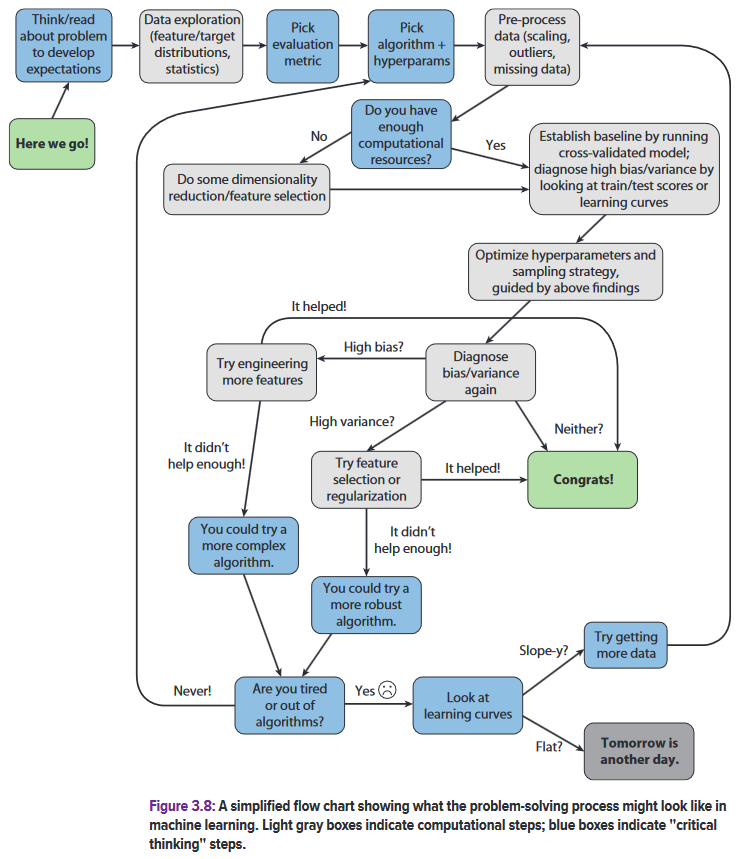

# data exploration

## load data

In [8]:
planets = pd.read_csv(filepath + 'hwc.csv', sep = ',')
# planets = original data

to keep names short but traceable, i prefer to create a dataframe for each operation or set of related operations. I add a suffix to their name (1, 2, 3,...) and leave a comment behind with info. I also avoid generic names like just `df` since i could read other data later and that would cause naming attriction. I reserve generic names for throwaway/testing variables

In [9]:
planets.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


## identify the columns, types, and size

In [10]:
planets.columns

Index(['P_NAME', 'P_DETECTION', 'P_DISCOVERY_FACILITY', 'P_YEAR', 'P_UPDATE',
       'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX', 'P_MASS_LIMIT',
       'P_MASS_ORIGIN',
       ...
       'S_ABIO_ZONE', 'S_TIDAL_LOCK', 'P_HABZONE_OPT', 'P_HABZONE_CON',
       'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI', 'S_CONSTELLATION',
       'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG'],
      dtype='object', length=118)

Notice there's quite a lot of columns in here (118). I could to research what each means (and the units used) before moving on. eg.

S_MAG - star magnitude 

S_DISTANCE - star distance (parsecs)

S_METALLICITY - star metallicity (dex)

S_MASS - star mass (solar units)

S_RADIUS - star radius (solar units)

S_AGE - star age (Gy)

S_TEMPERATURE - star effective temperature (K)

S_LOG_G - star log(g)

P_DISTANCE - planet mean distance from the star (AU) 

P_FLUX - planet mean stellar flux (earth units)

P_PERIOD - planet period (days)

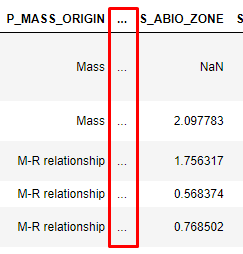

There's also missing values but we deal with them later

In [11]:
planets.dtypes

P_NAME                   object
P_DETECTION              object
P_DISCOVERY_FACILITY     object
P_YEAR                    int64
P_UPDATE                 object
                         ...   
P_HABITABLE               int64
P_ESI                   float64
S_CONSTELLATION          object
S_CONSTELLATION_ABR      object
S_CONSTELLATION_ENG      object
Length: 118, dtype: object

In [12]:
planets.shape

(5599, 118)

There's 5599 samples

In [13]:
planets.shape[0]*planets.shape[1]

660682

In [14]:
np.size(planets) # planets.size

660682

## select which columns to use

The target column is the habitability one

In [15]:
col_target = 'P_HABITABLE'
planets[col_target].head()

0    0
1    0
2    0
3    0
4    0
Name: P_HABITABLE, dtype: int64

In [16]:
planets[col_target].value_counts()

P_HABITABLE
0    5529
2      41
1      29
Name: count, dtype: int64

In [17]:
# another way of doing this

planets.groupby('P_HABITABLE').count()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
P_HABITABLE,,,,,,,,,,,,,,,,,,,,,
0,5529,5529,5529,5529,5529,5522,2471,2471,5529,5529,...,5296,5306,5525,5529,5529,5295,5288,5529,5529,5529
1,29,29,29,29,29,29,16,16,29,29,...,29,29,29,29,29,29,29,29,29,29
2,41,41,41,41,41,41,19,19,41,41,...,41,41,41,41,41,41,41,41,41,41


There's non-habitable = 0, habitable-conservative = 1 and habitable-optimistic = 2

But we want to reduce this to a binary classification problem, so we group the habitable into one

In [18]:
# one way of doing that

planets2 = planets.drop('P_HABITABLE', axis = 1) # create a new data frame called planets2 without the old habitability tag
planets2['P_HABITABLE'] = (np.logical_or((planets.P_HABITABLE == 1) , (planets.P_HABITABLE == 2))) # create the new habitability tag
planets2['P_HABITABLE'] = planets2['P_HABITABLE'].astype(int) # re-cast this column as integer

# planets2 = 'P_HABITABLE' is now binary

In [19]:
planets2[col_target].value_counts()

P_HABITABLE
0    5529
1      70
Name: count, dtype: int64

In [20]:
# other 2 ways of doing the same thing

# `apply()` and lambda function
planets2 = planets.drop('P_HABITABLE', axis=1)
planets2['P_HABITABLE'] = planets['P_HABITABLE'].apply(lambda x: 1 if x in [1, 2] else 0)

# `replace()`
planets2 = planets.drop('P_HABITABLE', axis=1)
planets2['P_HABITABLE'] = planets['P_HABITABLE'].replace({1: 1, 2: 1}).astype(int)

we also need to decide what other columns we want

In [21]:
cols_selected = ['S_MASS', 'P_PERIOD', 'P_DISTANCE', col_target]
planets3 = planets2[cols_selected]
planets3.head()

# planets3 = dataframe with only 'S_MASS', 'P_PERIOD', 'P_DISTANCE', 'P_HABITABLE'

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,0.10,NaN,3.4000,0
1,1.10,31.884000,0.1994,0
2,0.98,6.883376,0.0678,0
3,0.89,1.921036,0.0291,0
4,0.87,11.119907,0.0911,0


In [22]:
print(planets2.shape[1] - planets3.shape[1], "columns removed")

114 columns removed


## deal with missing values

missing values are `NaN`s or `None`s

There are various ways of identifying them

In [23]:
# isnull() or isna()
# return a dataframe of the same shape, with True where the values are missing and False where they are not
value_is_missing = planets3.isnull()  # or df.isna()
value_is_missing

# this is useful as a filter

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,False,True,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
5594,False,False,False,False
5595,False,False,False,False
5596,False,False,False,False
5597,False,False,False,False


In [24]:
# find columns with any missing values
cols_with_missing = value_is_missing.any()
cols_with_missing

S_MASS          True
P_PERIOD        True
P_DISTANCE      True
P_HABITABLE    False
dtype: bool

In [25]:
# # find rows with any missing values
rows_with_missing = value_is_missing.any(axis=1)

In [26]:
# count the number of missing values

# in each column
missing_count_per_col = value_is_missing.sum()
print(missing_count_per_col)

# total
print(sum(missing_count_per_col))

S_MASS           4
P_PERIOD       249
P_DISTANCE       4
P_HABITABLE      0
dtype: int64
257


In [27]:
# get the indices of missing values
missing_indices = planets3[rows_with_missing]
missing_indices

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,0.10,NaN,3.400,0
21,0.38,NaN,2.700,0
599,0.06,NaN,0.681,0
607,1.22,NaN,43.500,0
608,0.40,NaN,52.000,0
...,...,...,...,...
5575,0.91,NaN,1.840,0
5576,0.66,NaN,6.990,0
5591,0.39,NaN,2.440,0
5593,0.53,NaN,1.900,0


Once identified, you have to deal with them. There is no unique strategy to handle missing values.
* the most draconian option is to `discard` objects for which any of the features are missing, but this of course implies throwing away data, which is never ideal.
* another possible choice is to replace the missing value with some plausible estimate (called `imputing` in ML jargon), for example, the mean or median of that feature, or some plausible value coming from building a predictive model of the missing values (e.g., with a kNN!), using the other features as input 

In [28]:
# Manually remove missing values

# Identify missing values - create a boolean mask of rows (indices)
# True for rows with missing values
missing_mask = planets3.isnull().any(axis=1)

# Use the boolean mask to filter out rows
# keep only rows where missing_mask is False (i.e., no NaN)
planets4 = planets3[~missing_mask]

# planets4 = all missing values removed

In [29]:
# Remove rows with any missing values
df = planets3.dropna() # this is axis=0. axis=1 removes entire columns

In [30]:
# Remove rows with missing values in a specific column
df = planets3.dropna(subset=['P_PERIOD'])

In [31]:
planets4.shape

(5350, 4)

In [32]:
print(planets3.shape[0] - planets4.shape[0], "rows removed")

249 rows removed


However, notice that if we had separated the data into $X$ and $y$, we would now have to remove the corresponding entries from $y$, which we could do like this

In [33]:
y = planets.P_HABITABLE
X = planets[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
X2 = X.dropna()

# Get the indices of the rows that remain after dropping NaN in X
indices = X2.index

# Use the same indices to filter the y vector
y2 = y.loc[indices]

print(X2.shape, y2.shape)

(5350, 3) (5350,)


in terms of keeping up with the variables names this is not ideal because the effects on $y$ will only be seen after row operations, and column operations won't be tracked. Imo, it's better that, if you want to ignore the targets when filtering, you do that explicitly.

## identify outliers

* https://en.wikipedia.org/wiki/Outlier

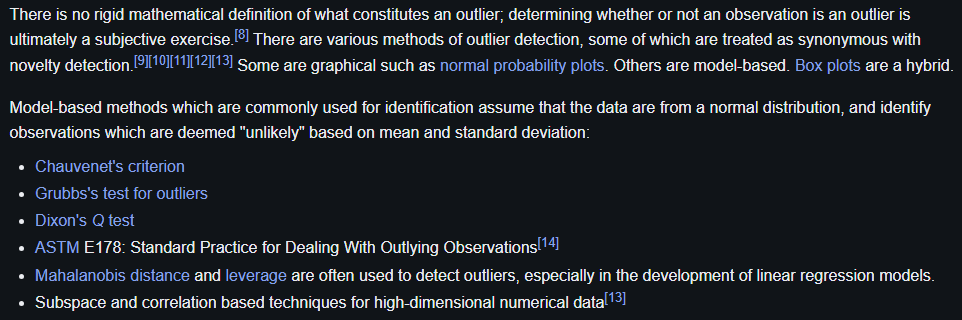

methods for outlier detection:
* statistical: Z-score, IQR
* visual: Box plot, Scatter plot
* machine learning: Isolation Forest, Local Outlier Factor (LOF)

The distributions of the features are quite skewed, and there are several `outliers`. These characteristics can be shown by plotting each feature as a histogram or just by using the `describe()` property of data frames in pandas and noticing that the mean and median of each distribution are quite far from each other. 

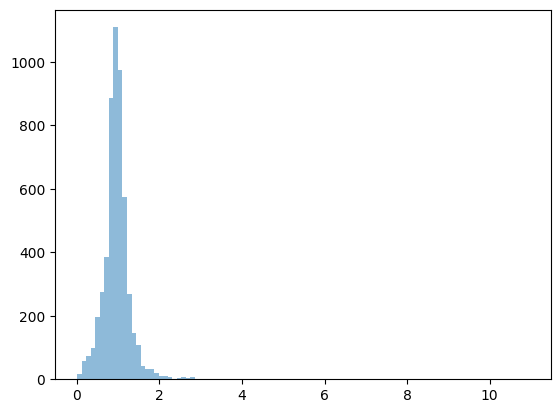

In [34]:
# histogram for the 1st feature
plt.hist(planets4.iloc[:,0], bins = 100, alpha = 0.5)
plt.show()

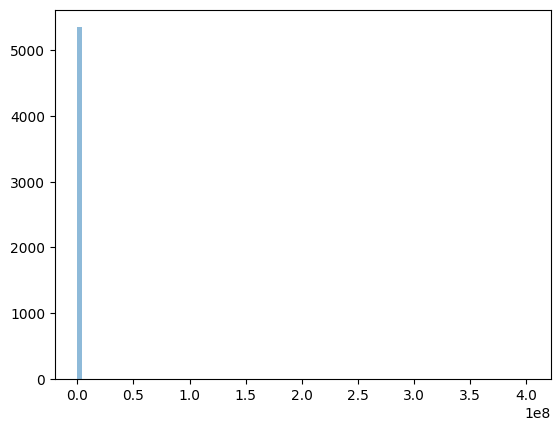

In [35]:
plt.hist(planets4.iloc[:,1], bins = 100, alpha = 0.5)
plt.show()

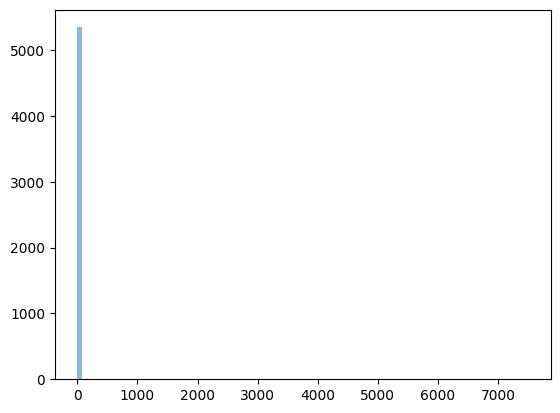

In [36]:
plt.hist(planets4.iloc[:,2], bins = 100, alpha = 0.5)
plt.show()

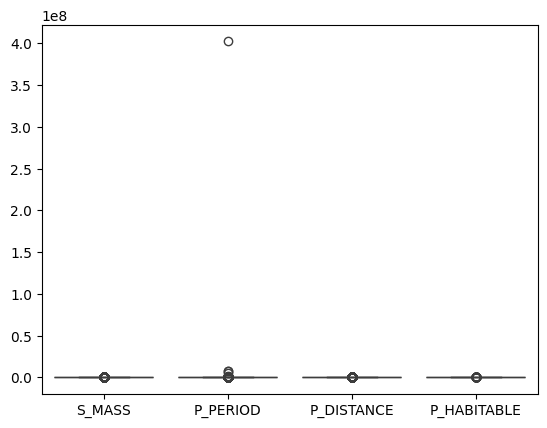

In [37]:
# Create a box plot for each column
sns.boxplot(data=planets4)
plt.show()
# Outliers will be displayed as individual points outside the whiskers.

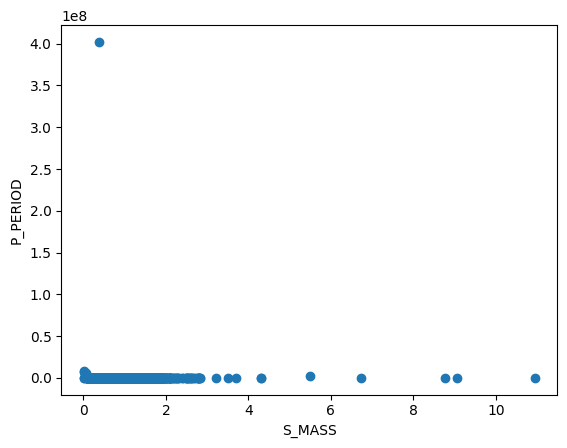

In [38]:
# For bivariate data, a scatter plot can help visualize outliers.
plt.scatter(planets4.iloc[:, 0], planets4.iloc[:, 1])
plt.xlabel(planets4.columns[0])
plt.ylabel(planets4.columns[1])
plt.show()

# Outliers are points that appear far from the main cluster

In [39]:
planets4.describe()

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
count,5350.000000,5.350000e+03,5350.000000,5350.000000
mean,0.967725,7.994082e+04,2.298436,0.013084
std,0.394993,5.498596e+06,103.218178,0.113646
min,0.010000,9.070629e-02,0.004408,0.000000
25%,0.810000,4.465382e+00,0.051900,0.000000
50%,0.950000,1.156951e+01,0.096550,0.000000
75%,1.100000,4.150555e+01,0.232000,0.000000
max,10.940000,4.020000e+08,7506.000000,1.000000


The `IQR` method focuses on the middle 50% of the data (the range between the 25th and 75th percentiles). Any point outside 1.5 times the IQR is considered an outlier

In [40]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = planets4.quantile(0.25)
Q1

S_MASS         0.810000
P_PERIOD       4.465382
P_DISTANCE     0.051900
P_HABITABLE    0.000000
Name: 0.25, dtype: float64

In [41]:
Q3 = planets4.quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
value_is_outlier = ((planets4 < lower_bound) | (planets4 > upper_bound))
value_is_outlier

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
5,False,False,False,False
...,...,...,...,...
5592,False,False,False,False
5594,False,True,True,False
5595,False,True,True,False
5596,False,False,False,False


In [42]:
value_is_outlier.sum().sum()

np.int64(2239)

Having identified outliers, we can opt to eliminate them. In particular, "severe outliers" might "skew" decisions made by our classifiers

This exclusion based on IQR would eliminate a lot of the data. Ofc, since there is no strict definition, we could ajust the lower and upper bound (for eg. to $3 \; \text{IQR}$ instead of $1.5 \; \text{IQR}$)

In [43]:
def my_outliers_IQR(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers_mask = ((df < lower_bound) | (df > upper_bound))
    
    # Rows that have at least one outlier
    row_has_outlier = outliers_mask.any(axis=1)
    
    # DataFrames for rows with and without outliers
    df_clean = df[~row_has_outlier]  # Without outliers
    df_outliers = df[row_has_outlier]  # Only outliers
    
    return df_clean, df_outliers

In [44]:
# version to ignore target columns

def my_outliers_IQR(df, ignore_columns=None):
    # If no columns to ignore, default to an empty list
    if ignore_columns is None:
        ignore_columns = []
    
    # Select the columns to consider for outlier detection
    columns_to_check = [col for col in df.columns if col not in ignore_columns]
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the selected columns
    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers in the selected columns
    outliers_mask = ((df[columns_to_check] < lower_bound) | (df[columns_to_check] > upper_bound))
    
    # Rows that have at least one outlier in the selected columns
    row_has_outlier = outliers_mask.any(axis=1)
    
    # DataFrames for rows with and without outliers (include all columns in the final result)
    df_clean = df[~row_has_outlier]  # Rows without outliers
    df_outliers = df[row_has_outlier]  # Rows with outliers

    return df_clean, df_outliers

In [45]:
df_clean, df_outliers = my_outliers_IQR(planets4, ignore_columns=[col_target])

The Z-score method works by excluding objects whose `z-score` (distance from mean, calculated in units of standard deviation) is larger than some desired value

The Z-score indicates how many standard deviations a data point is from the mean. Data points with a Z-score greater than a threshold (typically 3) are considered outliers.

In [46]:
columns_to_check = [col for col in df.columns if col != col_target]

In [47]:
# Calculate Z-scores for each column
z_scores = np.abs((planets4[columns_to_check] - planets4[columns_to_check].mean()) / planets4[columns_to_check].std())
z_scores.head()

,S_MASS,P_PERIOD,P_DISTANCE
1,0.334879,0.014533,0.020336
2,0.031076,0.014537,0.021611
3,0.196776,0.014538,0.021986
4,0.247410,0.014536,0.021385
5,0.728431,0.014537,0.021631


In [48]:
# (same thing, using scipy)
z_scores = scipy.stats.zscore(planets4[columns_to_check])
z_scores.head()

,S_MASS,P_PERIOD,P_DISTANCE
1,0.334910,-0.014534,-0.020338
2,0.031079,-0.014539,-0.021613
3,-0.196795,-0.014539,-0.021988
4,-0.247433,-0.014538,-0.021387
5,-0.728500,-0.014538,-0.021633


In [49]:
# Set threshold to 5
threshold = 5

# Find outliers
value_is_outlier = (z_scores > threshold)
value_is_outlier.head()

,S_MASS,P_PERIOD,P_DISTANCE
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False


In [50]:
# number of outliers
value_is_outlier.sum().sum()

np.int64(13)

In [51]:
# rows with outliers
row_has_outlier = value_is_outlier.any(axis=1)
row_has_outlier

1       False
2       False
3       False
4       False
5       False
        ...  
5592    False
5594    False
5595    False
5596    False
5597    False
Length: 5350, dtype: bool

In [52]:
# manually remove them
planets5 = planets4[~row_has_outlier]

# planets5 = outliers were removed

In [53]:
def my_outliers_zscore(df, threshold=3, ignore_columns=None):
    
    # If no columns to ignore, default to an empty list
    if ignore_columns is None:
        ignore_columns = []
    
    # Select the columns to consider for outlier detection
    columns_to_check = [col for col in df.columns if col not in ignore_columns]
    
    # Calculate Z-scores for each column
    z_scores = np.abs((df[columns_to_check] - df[columns_to_check].mean()) / df[columns_to_check].std())

    # Find outliers
    outliers_mask = (z_scores > threshold)
    
    # Rows that have at least one outlier
    row_has_outlier = outliers_mask.any(axis=1)
    
    # DataFrames for rows with and without outliers
    df_clean = df[~row_has_outlier]  # Without outliers
    df_outliers = df[row_has_outlier]  # Only outliers

    return df_clean, df_outliers

In [54]:
planets5.shape

(5339, 4)

In [55]:
print(planets4.shape[0] - planets5.shape[0], "rows removed")

11 rows removed


## check for class imbalance

in supervised classification, the classifier should be trained with a `balanced dataset`, that is, with data with the same number of examples for each class

In [56]:
planets5[col_target].value_counts()

P_HABITABLE
0    5269
1      70
Name: count, dtype: int64

Our data is very imbalanced, with many more examples of nonhabitable planets (0) than habitable ones (1)

In [58]:
planets5.groupby(col_target).describe(percentiles = [])

S_MASS                                       P_PERIOD  \
              count      mean       std   min   50%   max    count   
P_HABITABLE                                                          
0            5269.0  0.965409  0.304768  0.01  0.96  2.82   5269.0   
1              70.0  0.431714  0.247650  0.09  0.42  1.04     70.0   

                                                                          \
                    mean            std       min       50%          max   
P_HABITABLE                                                                
0            4532.574018  169610.983874  0.090706  11.33200  8040000.000   
1              73.921945      80.613442  4.049219  36.76998      384.843   

            P_DISTANCE                                                 
                 count      mean       std       min     50%      max  
P_HABITABLE                                                            
0               5269.0  0.788638  7.702383  0.004408  0.0958  430.920  
1                 70.0  0.255224  0.233825  0.022271  0.1647    1.046

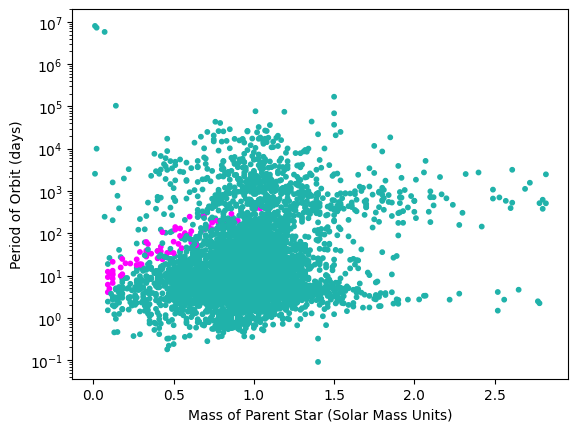

In [70]:
# take a look at the first two features

# Define a color map for the target column (e.g., 0 and 1)
colors = {0: '#20B2AA', 1: '#FF00FF'}  # Customize colors for different target values

# Map the target values to the corresponding colors
color_values = planets5[col_target].map(colors)

# Create the scatter plot with the mapped colors
plt.scatter(planets5['S_MASS'], planets5['P_PERIOD'], 
            marker='o', c=color_values, s=10)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Set plot labels
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)')

# Show the plot
plt.show()

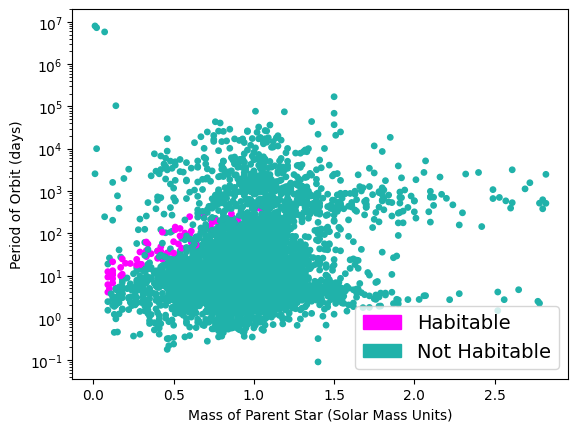

In [73]:
# to create a legend for the thing above, use mpatches
import matplotlib.patches as mpatches

# Define a color map for the target column (e.g., 0 and 1)
colors = {0: '#20B2AA', 1: '#FF00FF'}  # Customize colors for different target values

# Map the target values to the corresponding colors
color_values = planets5[col_target].map(colors)

# Create the scatter plot with the mapped colors
plt.scatter(planets5['S_MASS'], planets5['P_PERIOD'], 
            marker='o', c=color_values, s=15)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Set plot labels
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)')

# Create legend manually
habitable_patch = mpatches.Patch(color='#FF00FF', label='Habitable')
not_habitable_patch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
plt.legend(handles=[habitable_patch, not_habitable_patch], loc='lower right', fontsize=14)

# Show the plot
plt.show()

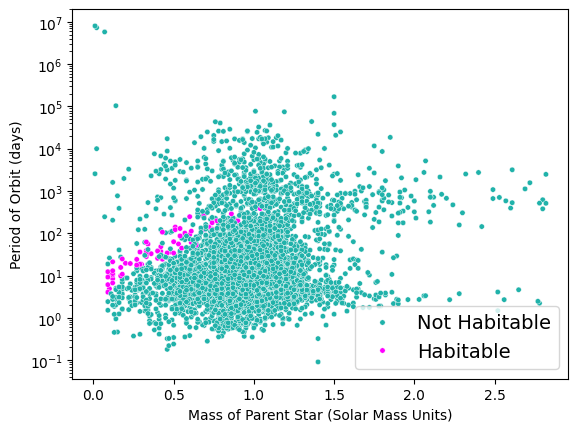

In [78]:
# same thing using seaborn

# Map integer values to labels
label_mapping = {0: 'Not Habitable', 1: 'Habitable'}
planets5.loc[:, 'label'] = planets5[col_target].map(label_mapping)

# Define the palette for the label values
palette = {'Not Habitable': '#20B2AA', 'Habitable': '#FF00FF'}

# Create the scatter plot using the mapped labels
sns.scatterplot(data=planets5, x='S_MASS', y='P_PERIOD', hue='label', 
                palette=palette, s=15)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Set plot labels
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)')

# The legend will automatically use the 'label' column for names
plt.legend(loc='lower right', fontsize=14)

# Show the plot
plt.show()

In [80]:
planets5.drop('label', axis = 1)

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
1,1.10,31.884000,0.199400,0
2,0.98,6.883376,0.067800,0
3,0.89,1.921036,0.029100,0
4,0.87,11.119907,0.091100,0
5,0.68,7.493134,0.065700,0
...,...,...,...,...
5592,0.84,3.770150,0.044721,0
5594,1.21,3999.000000,5.205792,0
5595,1.25,146.050000,0.596704,0
5596,0.99,29.334340,0.180159,0
